### Import libraries

In [42]:
import datetime

import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import rasterio
from rasterio.plot import show
from rasterio import features, warp

from shapely import wkt

from PIL import Image, ImageEnhance

### Load data into DataFrame (previously sumarized in a csv)

In [43]:
assets_train_df = pd.read_csv("data/assets_train.csv")

In [44]:
assets_test_df= pd.read_csv("data/assets_test.csv")

## Take a look on the raw data

The raw data is basically an index for the information saved in the different folders, separated by train and test data. 

In [45]:
assets_train_df.head(6)

tile_id                   datetime satellite_platform             asset  \
0     2587                        NaN                NaN     documentation   
1     2587                        NaN                NaN         field_ids   
2     2587                        NaN                NaN  field_info_train   
3     2587                        NaN                NaN            labels   
4     2587                        NaN                NaN     raster_values   
5     2587  2017-04-01 00:00:00+00:00                 s1                VH   

                                           file_path  \
0  /home/jupyter/NF-Capstone-Crop-Classification/...   
1  /home/jupyter/NF-Capstone-Crop-Classification/...   
2  /home/jupyter/NF-Capstone-Crop-Classification/...   
3  /home/jupyter/NF-Capstone-Crop-Classification/...   
4  /home/jupyter/NF-Capstone-Crop-Classification/...   
5  /home/jupyter/NF-Capstone-Crop-Classification/...   

                                            geometry        date  month  \
0                                                NaN         NaN    NaN   
1                                                NaN         NaN    NaN   
2                                                NaN         NaN    NaN   
3                                                NaN         NaN    NaN   
4                                                NaN         NaN    NaN   
5  {'coordinates': [[[18.572327426397308, -33.593...  2017-04-01    4.0   

   dayofyear  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5       91.0

### Show shape of DataFrame

In [46]:
assets_train_df.shape

(2039732, 9)

In [47]:
assets_test_df.head(6)

tile_id                   datetime satellite_platform              asset  \
0      590                        NaN                NaN      documentation   
1      590                        NaN                NaN          field_ids   
2      590                        NaN                NaN    field_info_test   
3      590                        NaN                NaN      raster_values   
4      590                        NaN                NaN  sample_submission   
5      590  2017-04-01 00:00:00+00:00                 s1                 VH   

                                           file_path  \
0  /home/jupyter/NF-Capstone-Crop-Classification/...   
1  /home/jupyter/NF-Capstone-Crop-Classification/...   
2  /home/jupyter/NF-Capstone-Crop-Classification/...   
3  /home/jupyter/NF-Capstone-Crop-Classification/...   
4  /home/jupyter/NF-Capstone-Crop-Classification/...   
5  /home/jupyter/NF-Capstone-Crop-Classification/...   

                                            geometry        date  month  \
0                                                NaN         NaN    NaN   
1                                                NaN         NaN    NaN   
2                                                NaN         NaN    NaN   
3                                                NaN         NaN    NaN   
4                                                NaN         NaN    NaN   
5  {'coordinates': [[[18.12207978150159, -33.0295...  2017-04-01    4.0   

   dayofyear  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5       91.0

### Show shape of DataFrame

In [48]:
assets_test_df.shape

(872188, 9)

### Add columns from timestamp

In [49]:
assets_train_df.datetime = pd.to_datetime(assets_train_df.datetime)

assets_train_df = assets_train_df.assign(
    date = lambda x: x['datetime'].dt.date,
    month = lambda x: x['datetime'].dt.month.astype('Int64'),
    dayofyear = lambda x: x['datetime'].dt.dayofyear.astype('Int64'),
)

### Assets of the DataFrame

In [50]:
assets_train_df['asset'].unique()

array(['documentation', 'field_ids', 'field_info_train', 'labels',
       'raster_values', 'VH', 'VV', 'B01', 'B02', 'B03', 'B04', 'B05',
       'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'CLM'],
      dtype=object)

### Tile_ids in DataFrame 

In [51]:
tile_id_list = assets_train_df.tile_id.unique()
print('First ID:',min(tile_id_list))
print('Last  ID:',max(tile_id_list))


First ID: 1
Last  ID: 2650


### How many images do we have per tile per satellite_platform?

In [52]:
tmp = assets_train_df.groupby(['tile_id','satellite_platform'])

In [53]:
days_per_tile = tmp.dayofyear.nunique().to_frame()

In [54]:
days_per_tile.rename({'dayofyear':'image_count'},axis=1,inplace=True)
days_per_tile

image_count
tile_id satellite_platform             
1       s1                           21
        s2                           76
2       s1                           21
        s2                           76
3       s1                           21
...                                 ...
2648    s2                           76
2649    s1                           21
        s2                           38
2650    s1                           21
        s2                           38

[5300 rows x 1 columns]

## Define colormap for all plots. Use viridis as base, use the color cycling when using 9 colors (9 crop types)

In [55]:
# create custom colormap
# 9 crop types
Ncolors = 9 

# base colormap is viridis (LinearSegmentedColormap)
colormap = plt.cm.GnBu
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
cmap = colors.ListedColormap(mapcolors)

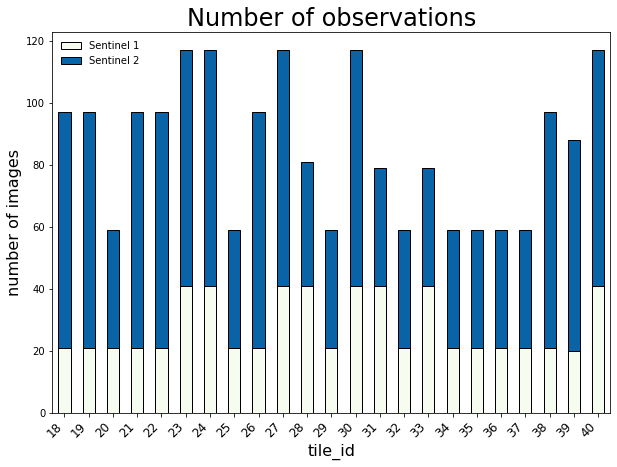

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
days_per_tile.iloc[34:80].unstack('satellite_platform').plot(kind='bar', edgecolor='black',stacked=True, ax=ax,width=0.5,cmap=cmap)

plt.xlabel('tile_id', fontsize = 16)
plt.ylabel("number of images", fontsize = 16)
plt.xticks(rotation=45, fontsize=12, ha='right')
legend = plt.legend(['Sentinel 1','Sentinel 2']);
legend.get_frame().set_alpha(0)
plt.title("Number of observations", fontsize = 24)

plt.savefig('pictures/satellite_freq.png', dpi=None, facecolor='auto', edgecolor='w',
            orientation='portrait',transparent=True)

### Fields in training data set

Fields have been extracted in Notebook `1_Data preparation`

In [57]:
fields_train = gpd.read_file('data/fields_train.geojson')
fields_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 87113 entries, 0 to 87112
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   field_id        87113 non-null  int64   
 1   label           87113 non-null  int64   
 2   tile_id         87113 non-null  int64   
 3   field_area_km2  87113 non-null  float64 
 4   elevation       87113 non-null  float64 
 5   geometry        87113 non-null  geometry
dtypes: float64(2), geometry(1), int64(3)
memory usage: 4.0 MB


In [58]:
from shapely import wkt

In [59]:
fields_train.head()

field_id  label  tile_id  field_area_km2   elevation  \
0      3020      2     2587        0.001702  197.333333   
1     99466      2     2587        0.042403  173.574074   
2     15902      5     2587        0.029503  149.222222   
3     38846      3     2587        0.069601   89.761364   
4     87981      1     2587        0.022603   90.272727   

                                            geometry  
0  POLYGON ((18.57295 -33.57073, 18.57293 -33.571...  
1  POLYGON ((18.57517 -33.57230, 18.57513 -33.573...  
2  POLYGON ((18.58087 -33.57259, 18.58087 -33.572...  
3  POLYGON ((18.59842 -33.57285, 18.59842 -33.572...  
4  POLYGON ((18.59189 -33.58714, 18.59186 -33.587...

### How many field_id's are on one tile_id?

In [60]:
fgb = fields_train.groupby('tile_id').field_id.nunique().to_frame()

In [61]:
fgb.columns = ['num_of_fields']

In [62]:
fgb.sort_values('num_of_fields', ascending=False, axis=0)

num_of_fields
tile_id               
127                431
1303               371
777                369
1264               336
190                332
...                ...
1621                 1
832                  1
1139                 1
1143                 1
2269                 1

[2650 rows x 1 columns]

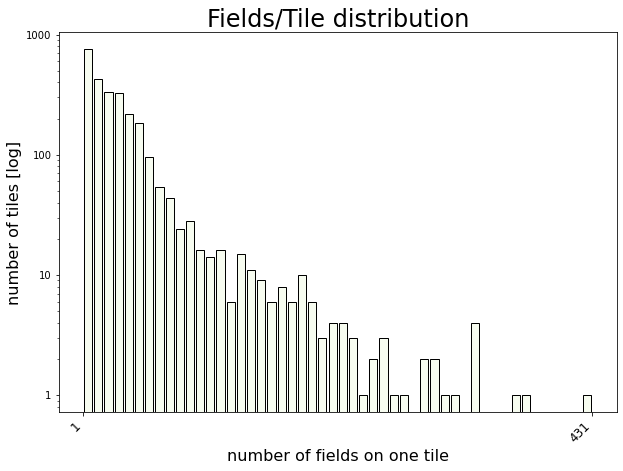

In [63]:
# plot number of field on one tile
fig, ax = plt.subplots(figsize=(10,7))
fgb.plot(kind='hist', edgecolor='black', ax=ax,bins = 50,cmap=cmap,rwidth=0.8)

# set y scale to logaritmic
ax.set_yscale('log')

plt.xlabel('number of fields on one tile', fontsize = 16)
plt.ylabel("number of tiles [log]", fontsize = 16)
plt.xticks([1,431],['1','431'],rotation=45, fontsize=12, ha='right')

# change yticks to scalar values instead of logaritmic
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

    # remove legend
ax.get_legend().remove();

plt.title("Fields/Tile distribution", fontsize = 24)

plt.savefig('pictures/fields_tile.png', dpi=None, facecolor='auto', edgecolor='w',
            orientation='portrait',transparent=True)

### Class distribution in fields_train 

In [64]:
# create dictionary, key = label, value = real name
crop_type = {}
for idx, crop in enumerate('N/A,Lucerne/Medics,Planted pastures,Fallow,Wine grapes,Weeds,Small grain grazing,Wheat,Canola,Rooibos'.split(',')):
    crop_type[str(idx)] = crop
crop_type

{'0': 'N/A',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

In [65]:
# create GeoDataFrame
fields_train = gpd.GeoDataFrame(fields_train,crs=4326,geometry='geometry')

In [66]:
# switch to meter- based coordinate system
fields_train = fields_train.to_crs(32634)
fields_train['area_km2'] = fields_train.area/1e6

**Create some images**

In [67]:
a = fields_train.groupby('label')['area_km2'].sum().to_frame()
a.rename({'label':'area'},axis=1,inplace=True)

In [68]:
c = fields_train.label.value_counts().to_frame()
c.rename({'label':'field_count'},axis=1,inplace=True)

In [69]:
tmp = pd.concat([c,a],axis=1)

In [70]:
tmp.field_count = tmp.field_count.apply(lambda x: x/tmp.field_count.max())

In [71]:
tmp.area_km2 = tmp.area_km2.apply(lambda x: x/tmp.area_km2.max())

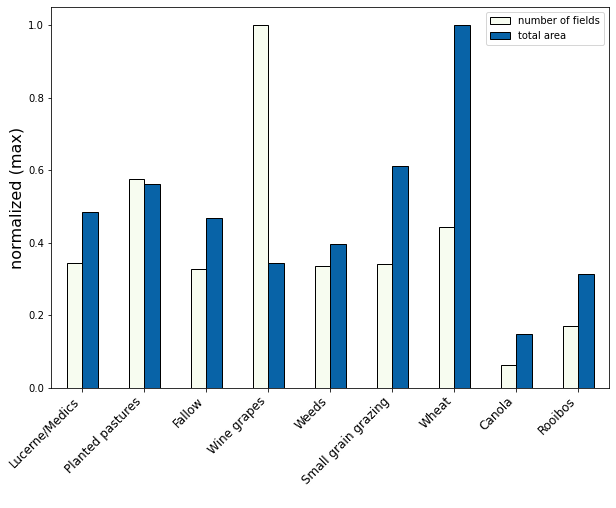

In [72]:
# plot figure
fig, ax = plt.subplots(figsize=(10,7))
tmp.plot(kind='bar', edgecolor='black', ax=ax, cmap=cmap)
plt.xlabel(' ')
plt.ylabel("normalized (max)", fontsize = 16)
# get xlabels and xtick positions
x_labels = ax.get_xticklabels()
# create dictionary of label and position
x_label_dict = dict([(x.get_text(), x.get_position()[0]) for x in x_labels])
# use values as xtick position, translate xlable to real label via crop_type dictionary
plt.xticks(list(x_label_dict.values()),[crop_type[x] for x in x_label_dict.keys()],rotation=45, fontsize=12, ha='right')
plt.legend(['number of fields','total area']);

Bilder von jedem Crop Type (ein Feld)

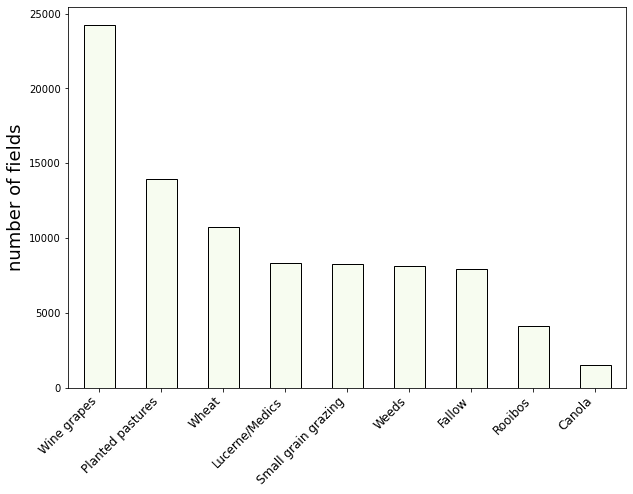

In [73]:
fig, ax = plt.subplots(figsize=(10,7))
fields_train.label.value_counts().plot(kind='bar',ax=ax,edgecolor='black',cmap=cmap)

# get xlabels and xtick positions
x_labels = ax.get_xticklabels()

# create dictionary of label and position
x_label_dict = dict([(x.get_text(), x.get_position()[0]) for x in x_labels])

# use values as xtick position, translate xlable to real label via crop_type dictionary
plt.xticks(list(x_label_dict.values()),[crop_type[x] for x in x_label_dict.keys()],rotation=45, fontsize=12, ha='right')
plt.ylabel('number of fields',fontsize=18);

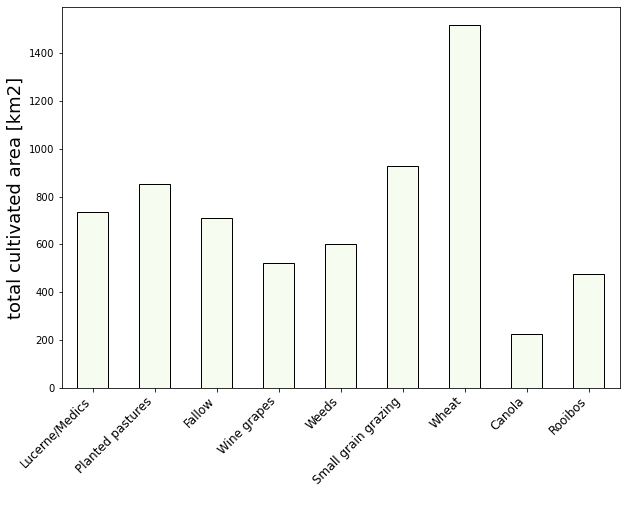

In [74]:
fig, ax = plt.subplots(figsize=(10,7))
fields_train.groupby('label')['area_km2'].sum().plot(kind='bar',ax=ax,edgecolor='black',cmap=cmap)

# get xlabels and xtick positions
x_labels = ax.get_xticklabels()

# create dictionary of label and position
x_label_dict = dict([(x.get_text(), x.get_position()[0]) for x in x_labels])

# use values as xtick position, translate xlable to real label via crop_type dictionary
plt.xticks(list(x_label_dict.values()),[crop_type[x] for x in x_label_dict.keys()],rotation=45, fontsize=12, ha='right')
plt.xlabel(' ')
plt.ylabel('total cultivated area [km2]',fontsize=18);

## Info concerning crop type

**Lucerne**
- different species, winter dormant to not winter dormant
- best panting period is February to May (autum)
- is planted in rows, space between rows 600-900mm
- https://de.wikipedia.org/wiki/Luzerne
- https://www.grainsa.co.za/conservation-agriculture:-part-8

**Planted pastures**
- https://southafrica.co.za/which-pasture-crops-plant.html

**Fallow**
- https://en.wikipedia.org/wiki/Fallow

**Wine**
- best palnting period August-September (is this applicable?)
- Irrigation March - May (Bewässerung)
- row spacing aprox. 2.4m
- ususally planted in north-south orientation
- https://en.wikipedia.org/wiki/Wine_regions_of_South_Africa

**Weeds**
- https://www.roundup-garden.co.za/weed-guide
   
**Wheat**
- best planting period mid-April - mid-June
- https://www.arc.agric.za/arc-sgi/Pages/General%20Information%20on%20SGI%20Homepage/Wheat.aspx

**Canola**
- planting period mid-April - mid-May
- optimum canola yield: uniform sized and evenly spaced seedling stand
- 40-50 plants/m2
- https://southafrica.co.za/canola-production.html

**Rooibos**
- harvesting period January to April
- planting period end of June
- row spacing aprox. 1m
- https://southafrica.co.za/rooibos-tea-production.html


Kepler Bild einfügen (Anbaugebiete farbig markiert) 
Tile einfärben nach häufigstem Crop type

### Let's plot some images

**Image over days**

In [75]:
tile_id=127
days_of_year = assets_train_df.query('tile_id == @tile_id & asset == "B02"')['dayofyear'].unique()
days_of_year

<IntegerArray>
[ 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 186, 191, 196, 201, 206,
 211, 216, 221, 226, 231, 236, 241, 251, 261, 266, 271, 276, 281, 286, 291,
 296, 301, 306, 311, 316, 321, 326, 331]
Length: 38, dtype: Int64

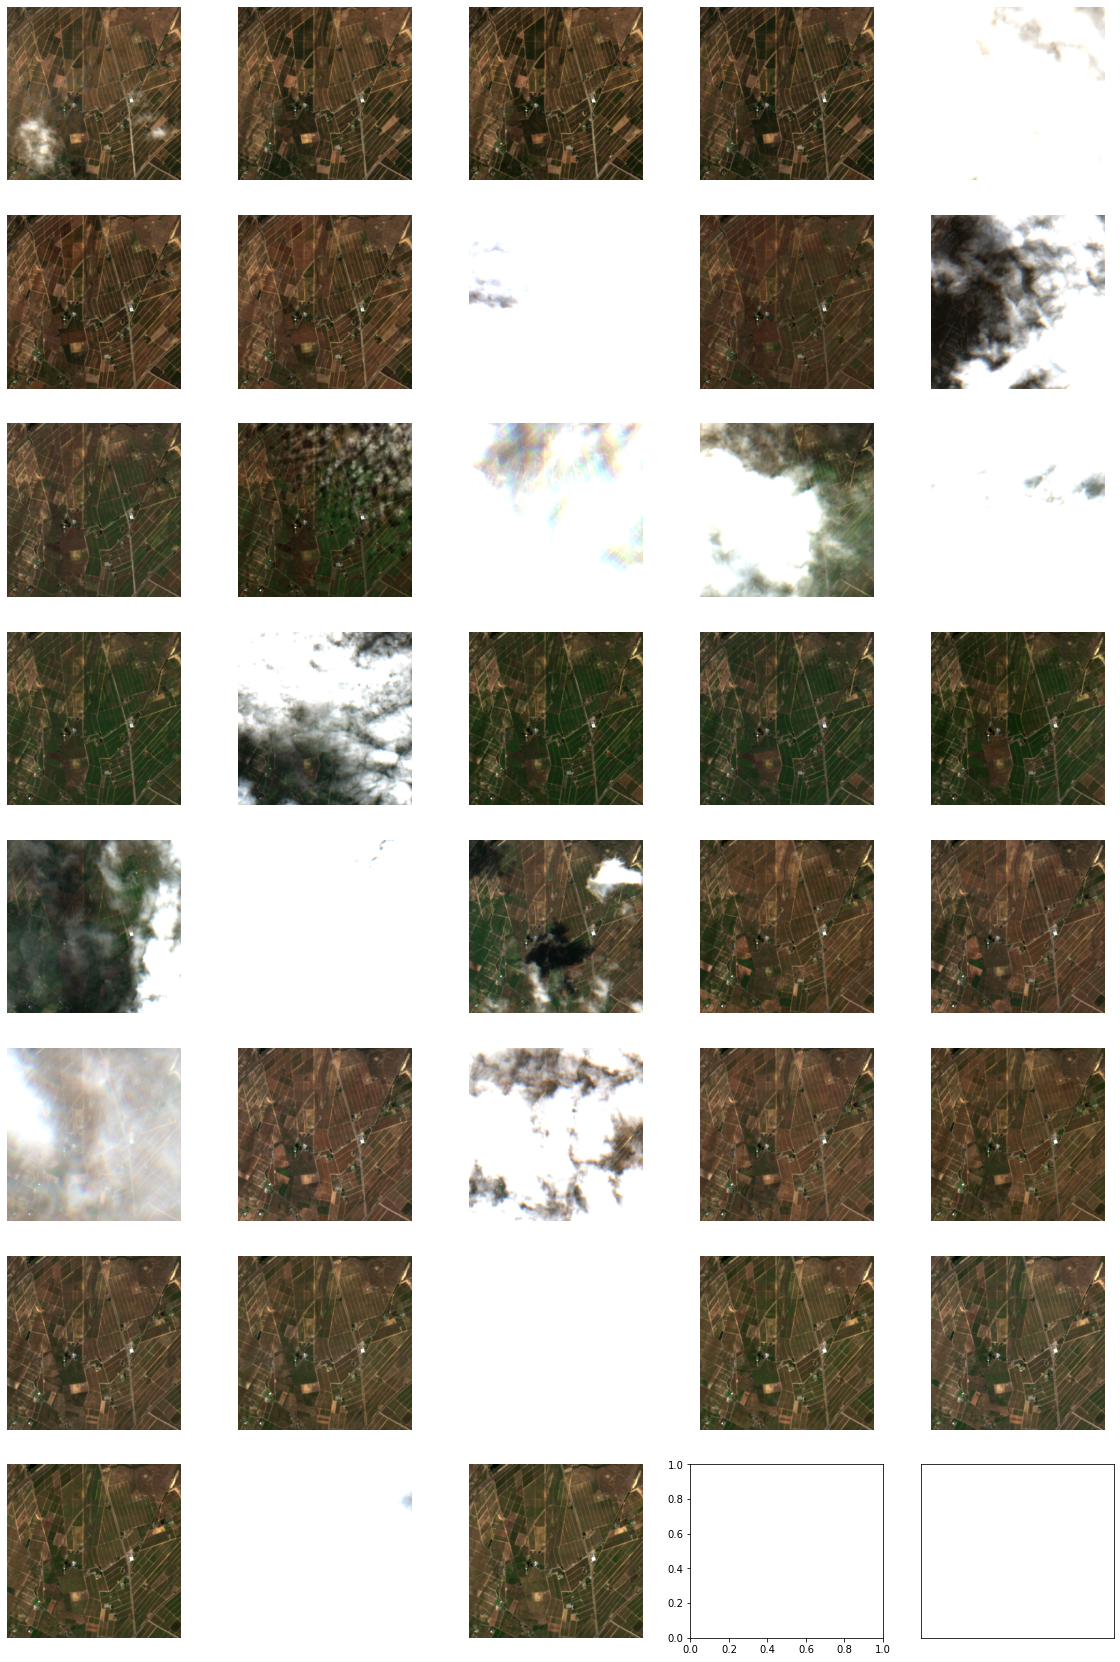

In [83]:
tile_id = 127

ncol = 5
nrow = int(len(days_of_year)/ncol) + 1 

fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=[20,30])
axs = axs.flatten()

for dayofyear, ax in zip (days_of_year, axs):

    pic = np.empty((256, 256, 3), dtype='uint8')
    
    ### red channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B04" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,0] = chan_rio.read()
    
    ### green channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B03" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,1] = chan_rio.read()
    
    ### blue channel
    chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B02" & dayofyear == @dayofyear').iloc[0,4])
    pic[:,:,2] = chan_rio.read()
    
    # create pillow image
    im = Image.fromarray(pic)

    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)
    
    factor = 3 #gives original image
    im_output = enhancer.enhance(factor)
    
    # turn off axis
    ax.axis('off')
    
    # remove axis ticks
    plt.xticks([])
    plt.yticks([])
    
    ax.imshow(im_output)

plt.savefig('pictures/days_field_RGB.png', dpi=None, facecolor='auto', edgecolor='w',
            orientation='portrait',transparent=True)

**Image, label and field_id**

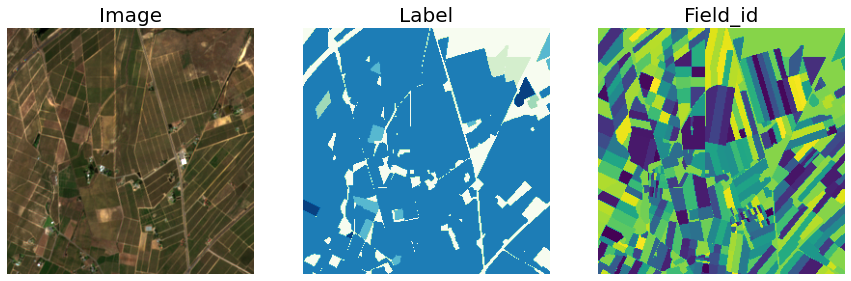

In [79]:
dayofyear = 331
tile_id = 127

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[15,15])
pic = np.empty((256, 256, 3), dtype='uint8')
### red channel
chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B04" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,0] = chan_rio.read()

### green channel
chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B03" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,1] = chan_rio.read()

### blue channel
chan_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "B02" & dayofyear == @dayofyear').iloc[0,4])
pic[:,:,2] = chan_rio.read()

# create pillow image
im = Image.fromarray(pic)

#image brightness enhancer
enhancer = ImageEnhance.Brightness(im)

factor = 3
im_output = enhancer.enhance(factor)

ax[0].imshow(im_output)


label_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "labels"').iloc[0,4])
ax[1].imshow(label_rio.read()[0,:,:], alpha=1, cmap='GnBu')#'Paired')

field_ids_rio = rasterio.open(assets_train_df.query('tile_id == @tile_id & asset == "field_ids"').iloc[0,4])

ids = field_ids_rio.read()[0,:,:]
ids[ids == 0] = 100000

ax[2].imshow(ids, alpha=1, cmap='viridis')#'Set1')
ax[0].set_title('Image',fontsize = 20)
ax[1].set_title('Label',fontsize = 20)
ax[2].set_title('Field_id', fontsize = 20);
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.savefig('pictures/Labels_field_id.png', dpi=None, facecolor='auto', edgecolor='w',
            orientation='portrait',transparent=True)

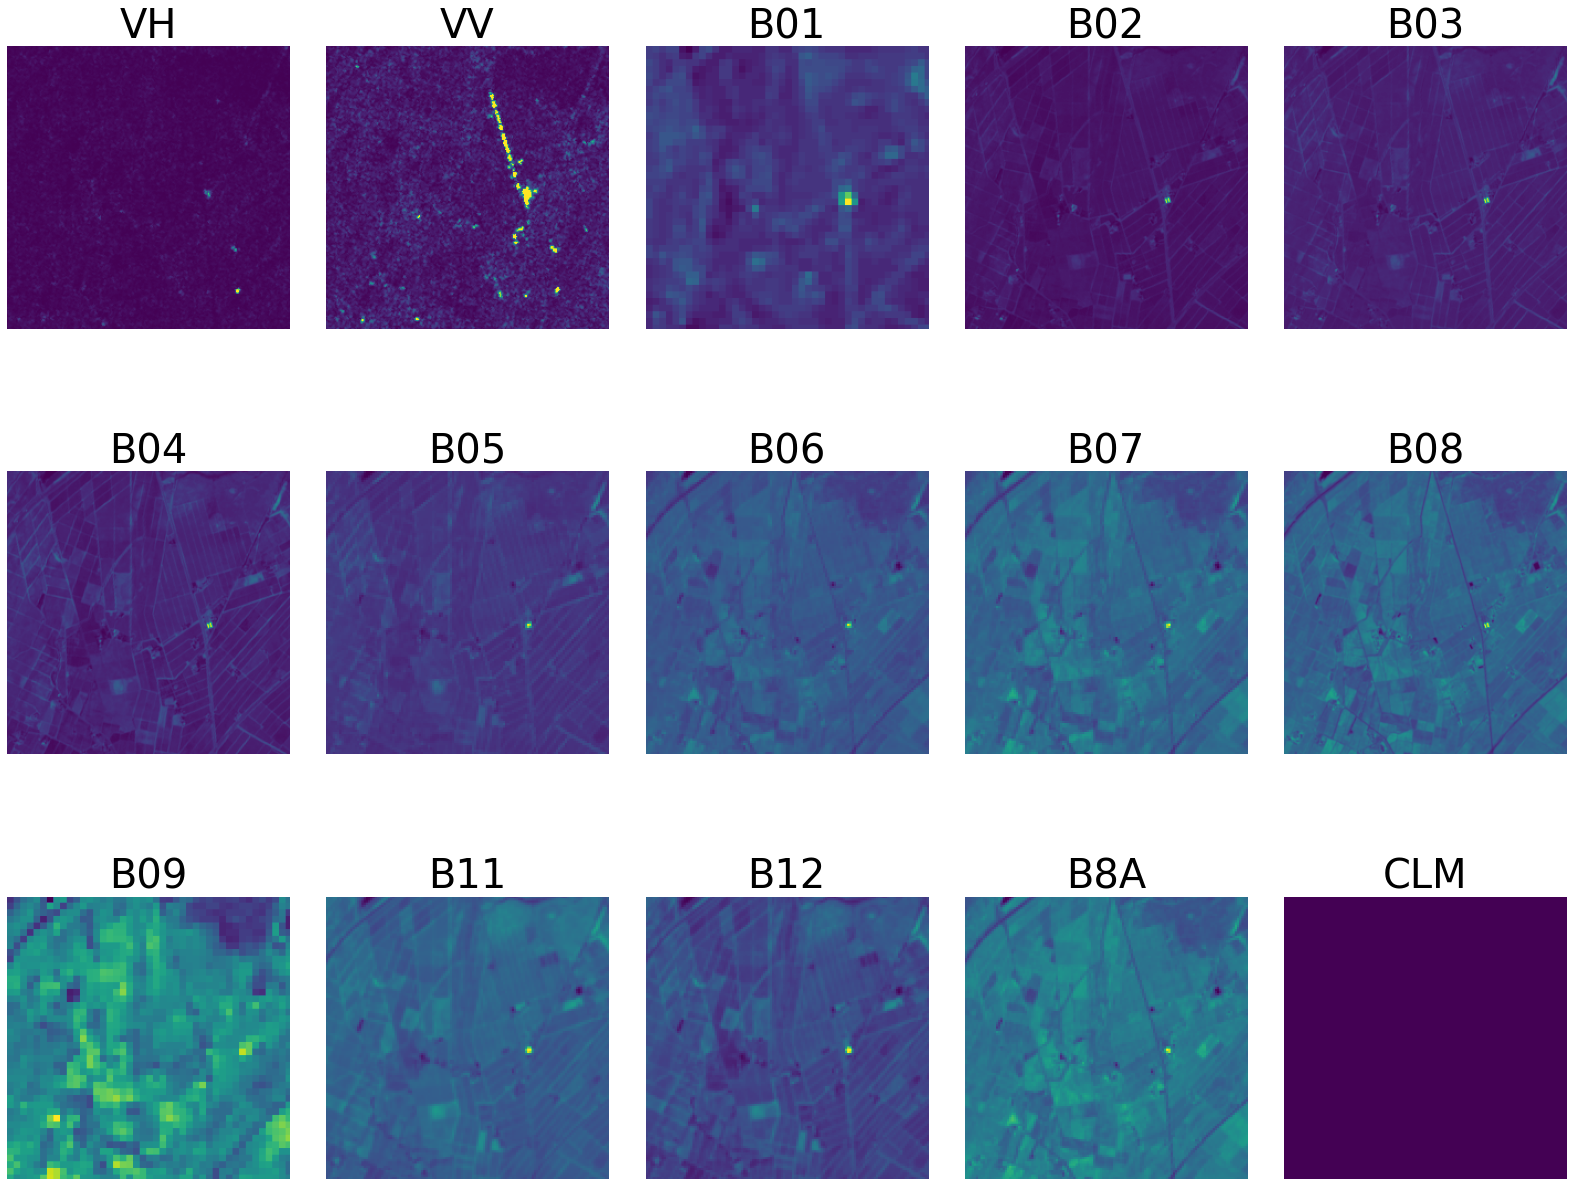

In [82]:
# create image for each layer
dayofyear = 331
tile_id = 127

chanels = ['VH', 'VV', 'B01', 'B02', 'B03', 'B04', 'B05','B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'CLM']

fig, axs = plt.subplots(ncols=len(chanels)//3, nrows=3, figsize=[22,22])
axs = axs.flatten()

for ax,chanel in zip(axs,chanels):
    chan_rio = rasterio.open(assets_train_df.query(f'tile_id == @tile_id & asset == "{chanel}" & dayofyear == @dayofyear').iloc[0,4])
    ax.imshow(chan_rio.read()[0,:,:])
    ax.set_title(f'{chanel}', fontsize=40)
    plt.tight_layout()
    ax.axis('off')

plt.savefig('bands.png', dpi=None, facecolor='auto', edgecolor='w',
            orientation='portrait',transparent=True)

In [1]:
# create B04, B03,B02

def img_creator(dayofyear, tile_id, bands, enh_fact=1):
    '''
    Creates png files out of rasterio chanels.
    Prerequisits: numpy and rasterio must be imported
    
    input:  dayofyear as integer
            tile_id as integer
            bands as list of strings
    output: png file, naming convention tile_id_dayofyear_band1_band2...png
    '''
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7,7])
    pic = np.empty((256, 256, len(bands)), dtype='uint8')

    for idx, band in enumerate(bands):
        chan_rio = rasterio.open(assets_train_df.query(f'tile_id == @tile_id & asset == "{band}" & dayofyear == @dayofyear').iloc[0,4])
        pic[:,:,idx] = chan_rio.read()

    # create pillow image
    im = Image.fromarray(pic)

    #image brightness enhancer
    enhancer = ImageEnhance.Brightness(im)

    im_output = enhancer.enhance(enh_fact)

    ax.imshow(im_output)
    ax.axis('off');
    plt.savefig(f'{tile_id}_{dayofyear}_' + '_'.join(bands) + '.png', dpi=None, facecolor='auto', edgecolor='auto',
                orientation='portrait',transparent=True)

In [2]:
dayofyear = 331
tile_id = 127
bands = ['B11', 'B08', 'B04']
img_creator(dayofyear, tile_id, bands)

NameError: name 'plt' is not defined

### Create plot with tiles position in South Africa, color indicates crop type which is planted most often on corresponding tile

In [41]:
# Load shapefile for outlines of South Africa
# Source: https://data.humdata.org/dataset/south-africa-admin-level-1-boundaries
# A good source for additional shape files is https://download.geofabrik.de/africa/south-africa.html (includes lot's of shapefiles such as roads or waterways)
zaf = gpd.read_file('SouthAfrica_shapefile/zaf_admbndl_admALL_sadb_ocha_itos_20201109.shp')

# there are diffeent levels of lines
#print(zaf.admLevel.unique())

# lines of admLevel 0,1,99 are what we need, create mask for df filtering
mask = zaf.admLevel.isin([99,0,1])

# filter dataframe
zaf = zaf.loc[mask]

***find most planted crop on each tile***

In [42]:
tmp = fields_train.groupby(['tile_id'])['label'].value_counts().to_frame()
tile_max_crop = tmp.groupby('tile_id').idxmax().reset_index()
tile_max_crop.label = tile_max_crop.label.apply(lambda x: x[1])
tile_max_crop.head()

tile_id  label
0        1      5
1        2      3
2        3      3
3        4      3
4        5      2

***sort tiles_train and join geometry column with tile_max_crop***

In [43]:
# import tiles_train
tiles_train = gpd.read_file('data/tiles_train.geojson')

In [44]:
tmp = tiles_train.sort_values('tile_id').geometry.to_frame().reset_index()
to_plot = tile_max_crop.join(tmp.geometry,how='left')
to_plot = gpd.GeoDataFrame(to_plot,geometry='geometry')
to_plot.head()

tile_id  label                                           geometry
0        1      5  POLYGON ((18.32342 -31.78748, 18.35043 -31.788...
1        2      3  POLYGON ((18.78601 -31.65784, 18.81299 -31.658...
2        3      3  POLYGON ((18.50316 -32.13743, 18.53028 -32.137...
3        4      3  POLYGON ((19.34398 -33.62890, 19.37157 -33.629...
4        5      2  POLYGON ((19.27623 -32.86610, 19.30358 -32.866...

In [45]:
# look for order of appearance of labels in 'to_plot', first label is going to be assigned the first color
seen = []
for i in to_plot.label:
    if not seen or not i in seen:
        seen.append(i)

# transalte labels into names via dictionary
# 'crop type' is a dictionary which has been created manually
labels = []
for label in seen:
    labels.append(crop_type[str(label)]) 

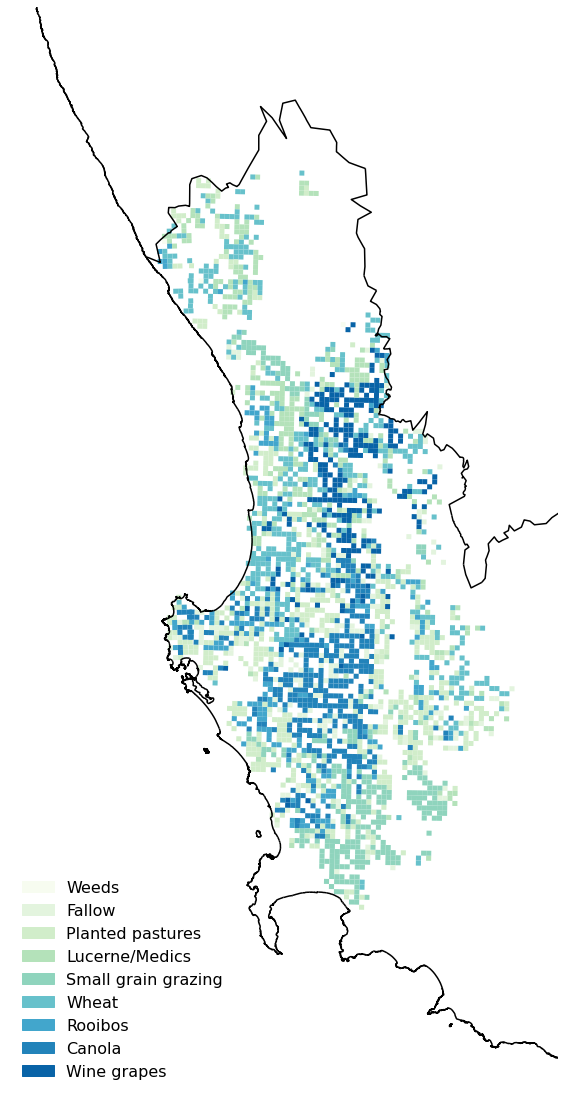

In [46]:
fig, ax = plt.subplots(figsize = (20,20))

# plot outline of South Africa
zaf.plot(ax=ax,color='black')

# plot tiles
to_plot.plot(column='label',ax=ax,cmap=cmap)

# create patches for custom legend
patches = []
for col, crop in zip(mapcolors, labels):
    patches.append(mpatches.Patch(color=col, label=crop)) 

# plot legend
legend = plt.legend(handles=patches, loc='lower left',fontsize=16)

# turn off axis
ax.axis('off')
    
# limit to western cape
plt.xlim(17,20)
plt.ylim(-35,-30)
legend.get_frame().set_alpha(0)

plt.savefig('pictures/tiles_max_crop.png', dpi=None, facecolor='auto', edgecolor='auto',
            orientation='portrait',transparent=True);

## Get elevation for all tiles

***load tile geometry*** 

In [47]:
tg = tiles_train[['tile_id','geometry']].copy()
tg.sort_values('tile_id', inplace=True)

***load elevetion data***

In [48]:
t=gpd.read_file('data/data_fields/fields_train.geojson')
ele=t.groupby('tile_id').elevation.mean().to_frame().reset_index()
ele.sort_values('tile_id', inplace=True)

In [49]:
# I do not know why, but I could not achieve this by Pandas join/concat/merge
joined = []
for idx, val in enumerate(ele.elevation):
    joined.append((val, tg.geometry.iloc[idx]))

In [50]:
# create DataFrame out of list
joined = pd.DataFrame(joined, columns=['elevation', 'geometry'])

In [51]:
# convert into GeoDataFrame for tile plotting
gdf = gpd.GeoDataFrame(joined, geometry='geometry', crs=4326)

In [52]:
gdf.head()

elevation                                           geometry
0  125.339909  POLYGON ((18.32342 -31.78748, 18.35043 -31.788...
1  160.665646  POLYGON ((18.78601 -31.65784, 18.81299 -31.658...
2  135.609589  POLYGON ((18.50316 -32.13743, 18.53028 -32.137...
3  235.804864  POLYGON ((19.34398 -33.62890, 19.37157 -33.629...
4  945.739229  POLYGON ((19.27623 -32.86610, 19.30358 -32.866...

In [65]:
ele_min = int(gdf.elevation.min())
ele_max = int(gdf.elevation.max())
print(f'minimum elevation (mean per tile): {ele_min}m')
print(f'maximum elevation (mean per tile): {ele_max}m')

minimum elevation (mean per tile): 4m
maximum elevation (mean per tile): 1225m


In [63]:
# create custom colormap
# 9 crop types
Ncolors = 9 

# base colormap is viridis (LinearSegmentedColormap)
colormap = plt.cm.rainbow
Ncolors = min(colormap.N,Ncolors)
mapcolors = [colormap(int(x*colormap.N/Ncolors)) for x in range(Ncolors)]
cmap = colors.ListedColormap(mapcolors)

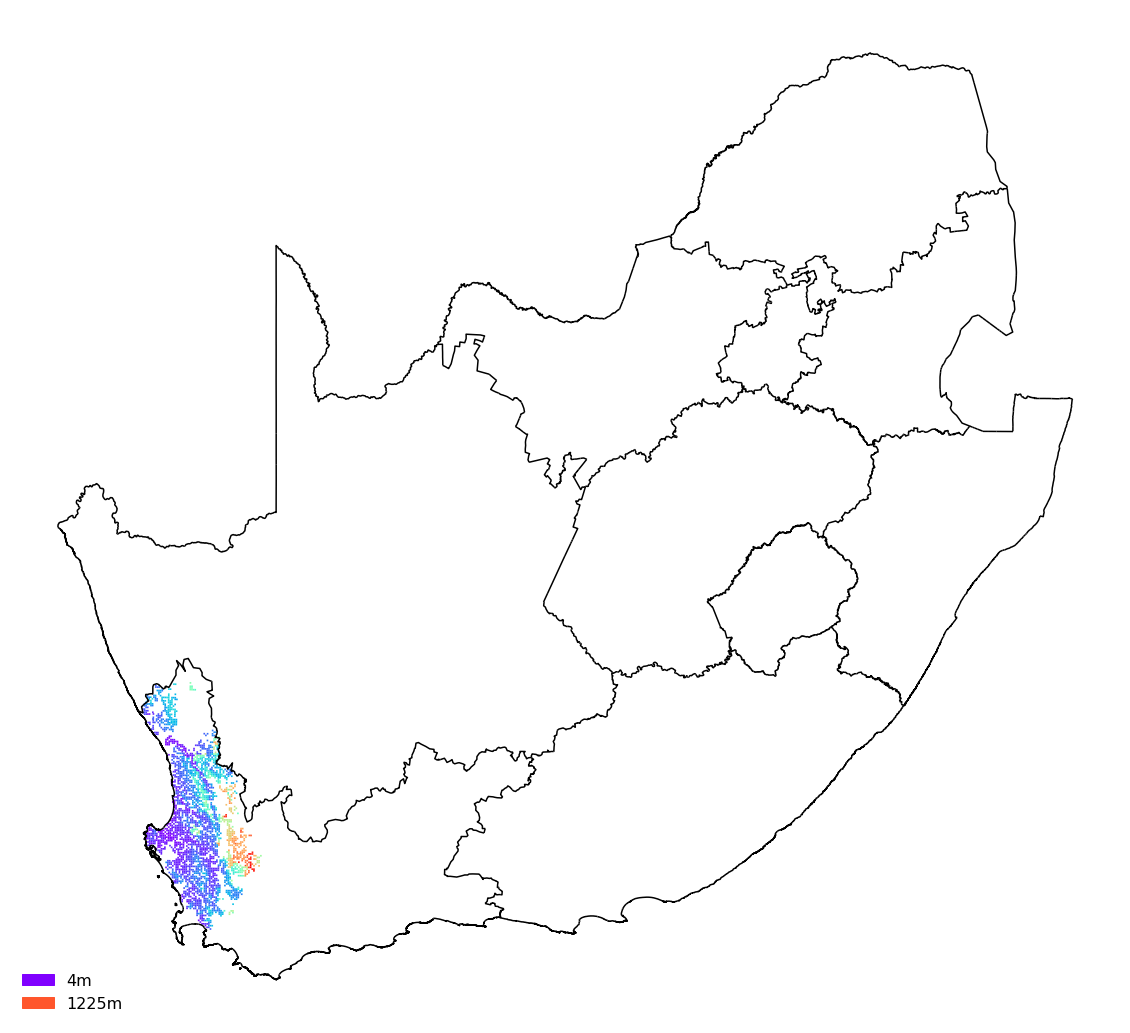

In [69]:
fig, ax = plt.subplots(figsize = (20,20))

# plot outline of South Africa
zaf.plot(ax=ax,color='black')

# plot tiles
gdf.plot(column='elevation',ax=ax,cmap='rainbow')

# create patches for custom legend
patches = []
#for col, crop in zip(mapcolors, labels):
patches.append(mpatches.Patch(color=mapcolors[0], label=f'{ele_min}m')) 
patches.append(mpatches.Patch(color=mapcolors[-1], label=f'{ele_max}m')) 

# plot legend
legend = plt.legend(handles=patches, loc='lower left',fontsize=16)

# turn off axis
ax.axis('off')
    
# limit to western cape
#plt.xlim(17,20)
#plt.ylim(-35,-30)
legend.get_frame().set_alpha(0)
plt.savefig('pictures/tiles_elevation.png', dpi=None, facecolor='auto', edgecolor='auto',
            orientation='portrait',transparent=True);

In [74]:
fields_train.head()

geometry  field_id  label  \
0  POLYGON ((274719.953 -3717199.976, 274719.971 ...      3020      2   
1  POLYGON ((274929.973 -3717370.056, 274929.958 ...     99466      2   
2  POLYGON ((275460.011 -3717389.950, 275459.969 ...     15902      5   
3  POLYGON ((277090.000 -3717379.972, 277089.953 ...     38846      3   
4  POLYGON ((276519.996 -3718979.951, 276519.954 ...     87981      1   

   tile_id  area_km2  
0     2587  0.001702  
1     2587  0.042403  
2     2587  0.029503  
3     2587  0.069601  
4     2587  0.022603

<AxesSubplot:>

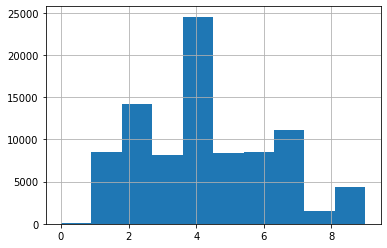

In [76]:
fields_train.label.hist()

In [94]:
fields_train.groupby('label')['area_km2'].describe()

count      mean           std       min       25%       50%  \
label                                                                  
0         60.0  0.000100  4.751026e-07  0.000099  0.000100  0.000100   
1       8548.0  0.086366  1.349328e-01  0.000099  0.008903  0.027899   
2      14233.0  0.060032  1.184754e-01  0.000099  0.008199  0.021399   
3       8158.0  0.087417  1.759021e-01  0.000099  0.008604  0.025800   
4      24560.0  0.021315  2.423232e-02  0.000099  0.007093  0.014602   
5       8412.0  0.071682  1.381196e-01  0.000099  0.009198  0.025403   
6       8540.0  0.109041  1.589776e-01  0.000099  0.015799  0.049802   
7      11138.0  0.136407  1.575236e-01  0.000099  0.022802  0.079396   
8       1542.0  0.145335  1.654400e-01  0.000100  0.026196  0.086334   
9       4378.0  0.108803  1.736828e-01  0.000099  0.014595  0.049146   

            75%       max  
label                      
0      0.000100  0.000101  
1      0.106091  1.775301  
2      0.059198  3.312108  
3      0.089574  3.135839  
4      0.027193  0.484307  
5      0.076498  2.719386  
6      0.140696  3.110866  
7      0.198504  1.427203  
8      0.206774  1.016292  
9      0.129102  3.339245

In [93]:
crop_type

{'0': 'N/A',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}